In [ ]:
!pip install -q segmentation-models-pytorch torchmetrics matplotlib

import os, time, json, platform, psutil
from pathlib import Path
from datetime import datetime
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import segmentation_models_pytorch as smp
from torchmetrics import JaccardIndex, Precision, Recall, F1Score
import matplotlib.pyplot as plt
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 31.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
def system_report():
    report = {
        "timestamp": datetime.now().isoformat(),
        "os": platform.platform(),
        "cpu": platform.processor(),
        "cpu_cores": psutil.cpu_count(logical=False),
        "cpu_threads": psutil.cpu_count(logical=True),
        "ram_gb": round(psutil.virtual_memory().total / (1024**3), 2),
        "gpu": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU",
        "gpu_memory_gb": torch.cuda.get_device_properties(0).total_memory / (1024**3) if torch.cuda.is_available() else 0,
        "cuda": torch.version.cuda if torch.cuda.is_available() else None,
        "torch": torch.__version__,
        "smp": smp.__version__,
    }
    return report

report = system_report()
print("\n=== SYSTEM REPORT ===")
for k, v in report.items():
    print(f"{k:20}: {v}")
print("======================\n")

ROOT = Path('/content/drive/MyDrive/Solor_Panels_Segmentation/model_development_dataset/')
train_img  = ROOT / 'train/img'
train_mask = ROOT / 'train/mask'
val_img    = ROOT / 'val/img'
val_mask   = ROOT / 'val/mask'

SAVE_DIR = Path('/content/drive/MyDrive/pspnet_checkpoints1')
SAVE_DIR.mkdir(exist_ok=True)


=== SYSTEM REPORT ===
timestamp           : 2025-10-31T05:16:10.182826
os                  : Linux-6.6.105+-x86_64-with-glibc2.35
cpu                 : x86_64
cpu_cores           : 1
cpu_threads         : 2
ram_gb              : 12.67
gpu                 : CPU
gpu_memory_gb       : 0
cuda                : None
torch               : 2.8.0+cu126
smp                 : 0.5.0



In [ ]:
import os
from pathlib import Path

image_paths = list(train_img.glob('*'))
image_paths = [p for p in image_paths if p.is_file()]

print(f"Number of training images: {len(image_paths)}")

Number of training images: 6415


In [ ]:
import os
from pathlib import Path

image_paths = list(val_img.glob('*'))
image_paths = [p for p in image_paths if p.is_file()]

print(f"Number of training images: {len(image_paths)}")

Number of training images: 1604


In [ ]:
IMG_SIZE = 256
class SolarPanelDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_tf=None, mask_tf=None):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.files = [f for f in os.listdir(img_dir) if f.lower().endswith('.png')]
        self.img_tf = img_tf
        self.mask_tf = mask_tf

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        img  = Image.open(self.img_dir / name).convert('RGB')
        mask = Image.open(self.mask_dir / name).convert('L')

        if self.img_tf:  img  = self.img_tf(img)
        if self.mask_tf: mask = self.mask_tf(mask)

        mask = (mask > 0.5).float()
        return img, mask

img_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

mask_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

train_ds = SolarPanelDataset(train_img, train_mask, img_tf, mask_tf)
val_ds   = SolarPanelDataset(val_img,   val_mask,   img_tf, mask_tf)

BATCH = 8
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True , num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds  , batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = smp.PSPNet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    classes=1,
    activation='sigmoid'
).to(device)

criterion = smp.losses.DiceLoss(mode='binary', from_logits=False)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

iou      = JaccardIndex(task='binary', threshold=0.5).to(device)
precision= Precision (task='binary', threshold=0.5).to(device)
recall   = Recall    (task='binary', threshold=0.5).to(device)
f1       = F1Score   (task='binary', threshold=0.5).to(device)

EPOCHS = 100
history = defaultdict(list)
best_miou = 0.0

for epoch in range(1, EPOCHS + 1):
    model.train()
    tr_loss = 0.0

    train_pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS} [Train]", leave=False)
    for img, msk in train_pbar:
        img, msk = img.to(device), msk.to(device)
        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, msk)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * img.size(0)
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    tr_loss /= len(train_ds)
    history['train_loss'].append(tr_loss)

    model.eval()
    val_loss = 0.0
    iou.reset(); precision.reset(); recall.reset(); f1.reset()

    val_pbar = tqdm(val_dl, desc=f"Epoch {epoch}/{EPOCHS} [Valid]", leave=False)
    with torch.no_grad():
        for img, msk in val_pbar:
            img, msk = img.to(device), msk.to(device)
            pred = model(img)
            loss = criterion(pred, msk)
            val_loss += loss.item() * img.size(0)

            pred_bin = (pred > 0.5).float()
            iou.update(pred_bin, msk)
            precision.update(pred_bin, msk)
            recall.update(pred_bin, msk)
            f1.update(pred_bin, msk)

            val_pbar.set_postfix({'val_loss': f'{loss.item():.4f}'})

    val_loss /= len(val_ds)
    miou = iou.compute().item()
    prec = precision.compute().item()
    rec = recall.compute().item()
    f1sc = f1.compute().item()

    history['val_loss'].append(val_loss)
    history['val_iou'].append(miou)
    history['val_prec'].append(prec)
    history['val_rec'].append(rec)
    history['val_f1'].append(f1sc)

    print(f"Epoch {epoch:02d} | "
          f"TrainLoss {tr_loss:.4f} | ValLoss {val_loss:.4f} | "
          f"IoU {miou:.4f} | Prec {prec:.4f} | Rec {rec:.4f} | F1 {f1sc:.4f}")

    epoch_path = SAVE_DIR / f"pspnet_epoch_{epoch}.pth"
    torch.save(model.state_dict(), epoch_path)

    if miou > best_miou:
        best_miou = miou
        best_path = SAVE_DIR / f"pspnet_best_epoch{epoch}_valIoU{best_miou:.4f}.pth"
        torch.save(model.state_dict(), best_path)
        print(f" → NEW BEST @ {best_path.name}")

Epoch 01 | TrainLoss 0.2127 | ValLoss 0.1447 | IoU 0.7526 | Prec 0.9560 | Rec 0.7796 | F1 0.8588
 → NEW BEST @ pspnet_best_epoch1_valIoU0.7526.pth


Epoch 02 | TrainLoss 0.1048 | ValLoss 0.1037 | IoU 0.8152 | Prec 0.9378 | Rec 0.8618 | F1 0.8982
 → NEW BEST @ pspnet_best_epoch2_valIoU0.8152.pth


Epoch 03 | TrainLoss 0.0860 | ValLoss 0.0960 | IoU 0.8234 | Prec 0.9397 | Rec 0.8694 | F1 0.9032
 → NEW BEST @ pspnet_best_epoch3_valIoU0.8234.pth


Epoch 04 | TrainLoss 0.0723 | ValLoss 0.0779 | IoU 0.8619 | Prec 0.9328 | Rec 0.9189 | F1 0.9258
 → NEW BEST @ pspnet_best_epoch4_valIoU0.8619.pth


Epoch 05 | TrainLoss 0.0642 | ValLoss 0.0751 | IoU 0.8666 | Prec 0.9181 | Rec 0.9393 | F1 0.9285
 → NEW BEST @ pspnet_best_epoch5_valIoU0.8666.pth


Epoch 06 | TrainLoss 0.0640 | ValLoss 0.0720 | IoU 0.8712 | Prec 0.9424 | Rec 0.9201 | F1 0.9311
 → NEW BEST @ pspnet_best_epoch6_valIoU0.8712.pth


Epoch 07 | TrainLoss 0.0568 | ValLoss 0.0693 | IoU 0.8774 | Prec 0.9207 | Rec 0.9492 | F1 0.9347
 → NEW BEST @ pspnet_best_epoch7_valIoU0.8774.pth


Epoch 08 | TrainLoss 0.0532 | ValLoss 0.0693 | IoU 0.8767 | Prec 0.9484 | Rec 0.9206 | F1 0.9343


Epoch 09 | TrainLoss 0.0544 | ValLoss 0.0674 | IoU 0.8803 | Prec 0.9367 | Rec 0.9360 | F1 0.9363
 → NEW BEST @ pspnet_best_epoch9_valIoU0.8803.pth


Epoch 10 | TrainLoss 0.0492 | ValLoss 0.0662 | IoU 0.8805 | Prec 0.9298 | Rec 0.9432 | F1 0.9365
 → NEW BEST @ pspnet_best_epoch10_valIoU0.8805.pth


Epoch 11 | TrainLoss 0.0463 | ValLoss 0.0650 | IoU 0.8837 | Prec 0.9454 | Rec 0.9312 | F1 0.9382
 → NEW BEST @ pspnet_best_epoch11_valIoU0.8837.pth


Epoch 12 | TrainLoss 0.0450 | ValLoss 0.0623 | IoU 0.8875 | Prec 0.9442 | Rec 0.9366 | F1 0.9404
 → NEW BEST @ pspnet_best_epoch12_valIoU0.8875.pth


Epoch 13 | TrainLoss 0.0449 | ValLoss 0.0657 | IoU 0.8818 | Prec 0.9372 | Rec 0.9372 | F1 0.9372


Epoch 14 | TrainLoss 0.0423 | ValLoss 0.0621 | IoU 0.8877 | Prec 0.9451 | Rec 0.9360 | F1 0.9405
 → NEW BEST @ pspnet_best_epoch14_valIoU0.8877.pth


Epoch 15 | TrainLoss 0.0404 | ValLoss 0.0621 | IoU 0.8881 | Prec 0.9477 | Rec 0.9339 | F1 0.9408
 → NEW BEST @ pspnet_best_epoch15_valIoU0.8881.pth


Epoch 16 | TrainLoss 0.0403 | ValLoss 0.0620 | IoU 0.8886 | Prec 0.9465 | Rec 0.9356 | F1 0.9410
 → NEW BEST @ pspnet_best_epoch16_valIoU0.8886.pth


Epoch 17 | TrainLoss 0.0384 | ValLoss 0.0625 | IoU 0.8872 | Prec 0.9526 | Rec 0.9282 | F1 0.9403


Epoch 18 | TrainLoss 0.0380 | ValLoss 0.0627 | IoU 0.8866 | Prec 0.9485 | Rec 0.9314 | F1 0.9399


Epoch 19 | TrainLoss 0.0399 | ValLoss 0.0634 | IoU 0.8856 | Prec 0.9602 | Rec 0.9194 | F1 0.9393


Epoch 20 | TrainLoss 0.0352 | ValLoss 0.0620 | IoU 0.8884 | Prec 0.9336 | Rec 0.9482 | F1 0.9409


Epoch 21 | TrainLoss 0.0369 | ValLoss 0.0601 | IoU 0.8913 | Prec 0.9479 | Rec 0.9372 | F1 0.9425
 → NEW BEST @ pspnet_best_epoch21_valIoU0.8913.pth


Epoch 22 | TrainLoss 0.0342 | ValLoss 0.0612 | IoU 0.8902 | Prec 0.9442 | Rec 0.9397 | F1 0.9419


Epoch 23 | TrainLoss 0.0331 | ValLoss 0.0618 | IoU 0.8885 | Prec 0.9457 | Rec 0.9363 | F1 0.9410


Epoch 24 | TrainLoss 0.0341 | ValLoss 0.0611 | IoU 0.8894 | Prec 0.9460 | Rec 0.9369 | F1 0.9414


Epoch 25 | TrainLoss 0.0324 | ValLoss 0.0603 | IoU 0.8905 | Prec 0.9435 | Rec 0.9407 | F1 0.9421


Epoch 26 | TrainLoss 0.0327 | ValLoss 0.0616 | IoU 0.8883 | Prec 0.9568 | Rec 0.9254 | F1 0.9408


Epoch 27 | TrainLoss 0.0312 | ValLoss 0.0613 | IoU 0.8894 | Prec 0.9458 | Rec 0.9372 | F1 0.9415


Epoch 28 | TrainLoss 0.0312 | ValLoss 0.0619 | IoU 0.8886 | Prec 0.9519 | Rec 0.9303 | F1 0.9410


Epoch 29 | TrainLoss 0.0304 | ValLoss 0.0620 | IoU 0.8880 | Prec 0.9482 | Rec 0.9333 | F1 0.9407


Epoch 30 | TrainLoss 0.0328 | ValLoss 0.0599 | IoU 0.8920 | Prec 0.9523 | Rec 0.9337 | F1 0.9429
 → NEW BEST @ pspnet_best_epoch30_valIoU0.8920.pth


Epoch 31 | TrainLoss 0.0297 | ValLoss 0.0612 | IoU 0.8893 | Prec 0.9528 | Rec 0.9303 | F1 0.9414


Epoch 32 | TrainLoss 0.0288 | ValLoss 0.0609 | IoU 0.8892 | Prec 0.9399 | Rec 0.9428 | F1 0.9413


Epoch 33 | TrainLoss 0.0284 | ValLoss 0.0599 | IoU 0.8912 | Prec 0.9510 | Rec 0.9340 | F1 0.9425


Epoch 34 | TrainLoss 0.0282 | ValLoss 0.0612 | IoU 0.8890 | Prec 0.9387 | Rec 0.9439 | F1 0.9413


Epoch 35 | TrainLoss 0.0283 | ValLoss 0.0610 | IoU 0.8895 | Prec 0.9513 | Rec 0.9319 | F1 0.9415


Epoch 36 | TrainLoss 0.0289 | ValLoss 0.0613 | IoU 0.8891 | Prec 0.9479 | Rec 0.9348 | F1 0.9413


Epoch 37 | TrainLoss 0.0287 | ValLoss 0.0600 | IoU 0.8909 | Prec 0.9466 | Rec 0.9381 | F1 0.9423


Epoch 38 | TrainLoss 0.0269 | ValLoss 0.0618 | IoU 0.8880 | Prec 0.9436 | Rec 0.9378 | F1 0.9407


Epoch 39 | TrainLoss 0.0269 | ValLoss 0.0613 | IoU 0.8885 | Prec 0.9540 | Rec 0.9283 | F1 0.9410


Epoch 40 | TrainLoss 0.0269 | ValLoss 0.0600 | IoU 0.8912 | Prec 0.9432 | Rec 0.9417 | F1 0.9425


Epoch 41 | TrainLoss 0.0280 | ValLoss 0.0597 | IoU 0.8912 | Prec 0.9448 | Rec 0.9402 | F1 0.9425


Epoch 42 | TrainLoss 0.0265 | ValLoss 0.0594 | IoU 0.8920 | Prec 0.9488 | Rec 0.9371 | F1 0.9429


Epoch 43 | TrainLoss 0.0259 | ValLoss 0.0606 | IoU 0.8903 | Prec 0.9505 | Rec 0.9336 | F1 0.9420


Epoch 44 | TrainLoss 0.0258 | ValLoss 0.0605 | IoU 0.8898 | Prec 0.9523 | Rec 0.9312 | F1 0.9417


Epoch 45 | TrainLoss 0.0260 | ValLoss 0.0608 | IoU 0.8893 | Prec 0.9499 | Rec 0.9330 | F1 0.9414


Epoch 46 | TrainLoss 0.0254 | ValLoss 0.0605 | IoU 0.8901 | Prec 0.9436 | Rec 0.9402 | F1 0.9419


Epoch 47 | TrainLoss 0.0251 | ValLoss 0.0608 | IoU 0.8896 | Prec 0.9406 | Rec 0.9425 | F1 0.9416


Epoch 48 | TrainLoss 0.0258 | ValLoss 0.0611 | IoU 0.8890 | Prec 0.9451 | Rec 0.9375 | F1 0.9413


Epoch 49 | TrainLoss 0.0286 | ValLoss 0.0605 | IoU 0.8902 | Prec 0.9534 | Rec 0.9307 | F1 0.9419


Epoch 50 | TrainLoss 0.0254 | ValLoss 0.0575 | IoU 0.8956 | Prec 0.9465 | Rec 0.9433 | F1 0.9449
 → NEW BEST @ pspnet_best_epoch50_valIoU0.8956.pth


Epoch 51 | TrainLoss 0.0240 | ValLoss 0.0588 | IoU 0.8933 | Prec 0.9482 | Rec 0.9391 | F1 0.9436


Epoch 52 | TrainLoss 0.0240 | ValLoss 0.0589 | IoU 0.8934 | Prec 0.9500 | Rec 0.9374 | F1 0.9437


Epoch 53 | TrainLoss 0.0240 | ValLoss 0.0593 | IoU 0.8923 | Prec 0.9527 | Rec 0.9336 | F1 0.9431


Epoch 54 | TrainLoss 0.0241 | ValLoss 0.0599 | IoU 0.8913 | Prec 0.9528 | Rec 0.9324 | F1 0.9425


Epoch 55 | TrainLoss 0.0243 | ValLoss 0.0585 | IoU 0.8939 | Prec 0.9475 | Rec 0.9405 | F1 0.9440


Epoch 56 | TrainLoss 0.0257 | ValLoss 0.0592 | IoU 0.8921 | Prec 0.9539 | Rec 0.9323 | F1 0.9430


Epoch 57 | TrainLoss 0.0236 | ValLoss 0.0586 | IoU 0.8935 | Prec 0.9462 | Rec 0.9413 | F1 0.9437


Epoch 58 | TrainLoss 0.0236 | ValLoss 0.0594 | IoU 0.8918 | Prec 0.9478 | Rec 0.9378 | F1 0.9428


Epoch 59 | TrainLoss 0.0234 | ValLoss 0.0584 | IoU 0.8935 | Prec 0.9480 | Rec 0.9396 | F1 0.9438


Epoch 60 | TrainLoss 0.0234 | ValLoss 0.0607 | IoU 0.8893 | Prec 0.9429 | Rec 0.9399 | F1 0.9414


Epoch 61 | TrainLoss 0.0237 | ValLoss 0.0638 | IoU 0.8839 | Prec 0.9334 | Rec 0.9434 | F1 0.9384


Epoch 62 | TrainLoss 0.0235 | ValLoss 0.0592 | IoU 0.8922 | Prec 0.9457 | Rec 0.9403 | F1 0.9430


Epoch 63 | TrainLoss 0.0230 | ValLoss 0.0600 | IoU 0.8907 | Prec 0.9433 | Rec 0.9411 | F1 0.9422


Epoch 64 | TrainLoss 0.0229 | ValLoss 0.0599 | IoU 0.8908 | Prec 0.9496 | Rec 0.9350 | F1 0.9422


Epoch 65 | TrainLoss 0.0229 | ValLoss 0.0599 | IoU 0.8910 | Prec 0.9462 | Rec 0.9386 | F1 0.9424


Epoch 66 | TrainLoss 0.0228 | ValLoss 0.0602 | IoU 0.8907 | Prec 0.9536 | Rec 0.9310 | F1 0.9422


Epoch 67 | TrainLoss 0.0230 | ValLoss 0.0600 | IoU 0.8910 | Prec 0.9504 | Rec 0.9345 | F1 0.9424


Epoch 68 | TrainLoss 0.0226 | ValLoss 0.0587 | IoU 0.8934 | Prec 0.9498 | Rec 0.9376 | F1 0.9437


Epoch 69 | TrainLoss 0.0227 | ValLoss 0.0599 | IoU 0.8907 | Prec 0.9461 | Rec 0.9384 | F1 0.9422


Epoch 70 | TrainLoss 0.0254 | ValLoss 0.0725 | IoU 0.8692 | Prec 0.9231 | Rec 0.9371 | F1 0.9300


Epoch 71 | TrainLoss 0.0239 | ValLoss 0.0592 | IoU 0.8917 | Prec 0.9558 | Rec 0.9301 | F1 0.9428


Epoch 72 | TrainLoss 0.0216 | ValLoss 0.0585 | IoU 0.8933 | Prec 0.9457 | Rec 0.9416 | F1 0.9436


Epoch 73 | TrainLoss 0.0215 | ValLoss 0.0598 | IoU 0.8910 | Prec 0.9565 | Rec 0.9286 | F1 0.9423


Epoch 74 | TrainLoss 0.0217 | ValLoss 0.0600 | IoU 0.8905 | Prec 0.9481 | Rec 0.9361 | F1 0.9421


Epoch 75 | TrainLoss 0.0219 | ValLoss 0.0599 | IoU 0.8908 | Prec 0.9501 | Rec 0.9344 | F1 0.9422


Epoch 76 | TrainLoss 0.0220 | ValLoss 0.0586 | IoU 0.8933 | Prec 0.9437 | Rec 0.9436 | F1 0.9437


Epoch 77/100 [Train]:  94%|█████████▎| 750/802 [01:27<00:09,  5.42it/s, loss=0.0220]

In [ ]:
IMG_SIZE = 256

img_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

mask_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.NEAREST),
    transforms.ToTensor()
])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = smp.PSPNet(
    encoder_name="resnet50",
    encoder_weights=None,
    classes=1,
    activation='sigmoid'
).to(device)

# Path to checkpoint
checkpoint_path = Path("/content/drive/MyDrive/pspnet_checkpoints1/pspnet_best_epoch50_valIoU0.8956.pth")

# Load weights
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print("✅ Model loaded successfully from:", checkpoint_path)


✅ Model loaded successfully from: /content/drive/MyDrive/pspnet_checkpoints1/pspnet_best_epoch50_valIoU0.8956.pth


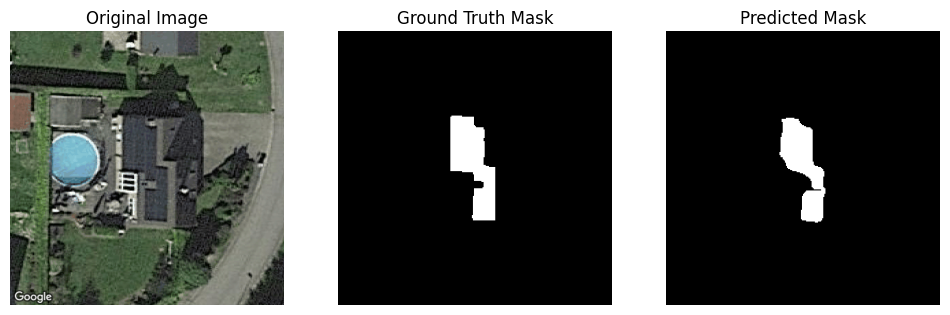

In [ ]:
ROOT = Path('/content/drive/MyDrive/Solor_Panels_Segmentation/model_development_dataset')
img_path = ROOT / 'val/img/STFNN6D12IUTJU.png'
mask_path = ROOT / 'val/mask/STFNN6D12IUTJU.png'

img = Image.open(img_path).convert('RGB')
mask = Image.open(mask_path).convert('L')

img_t = img_tf(img).unsqueeze(0).to(device)
mask_t = mask_tf(mask).to(device)

with torch.no_grad():
    pred = model(img_t)
    pred_bin = (pred > 0.5).float()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask_t.squeeze().cpu(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_bin.squeeze().cpu(), cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


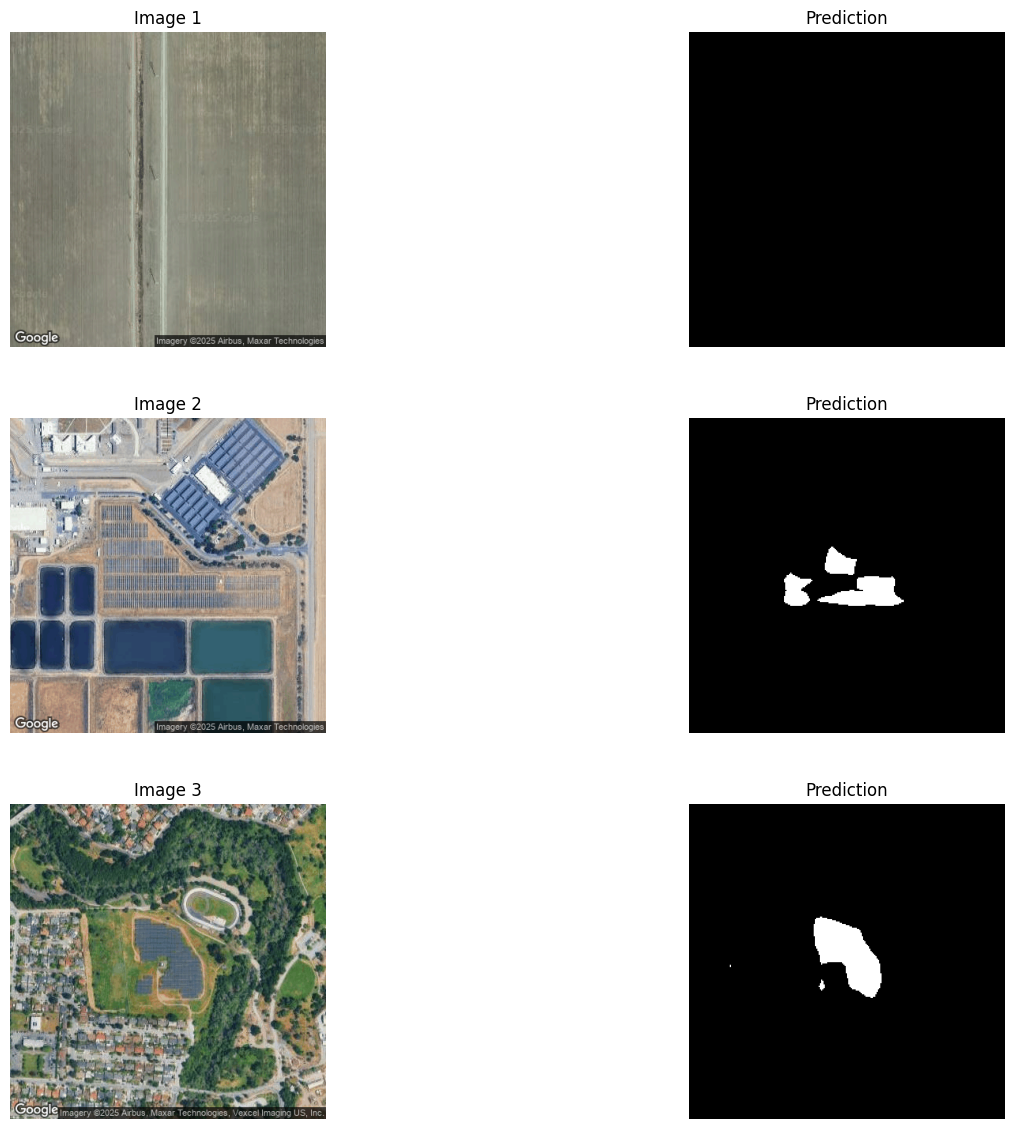

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch

# -------- CONFIG --------
IMG_DIR = Path('/content/drive/MyDrive/Solor_Panels_Segmentation/independent_test_dataset/annotation_images/Shrushti')

filenames = [
    '404571.png',
    '403903.png',
    '403145.png'
]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.tight_layout(pad=3)

for i, fname in enumerate(filenames):
    img_path = IMG_DIR / fname
    img = Image.open(img_path).convert('RGB')
    img_t = img_tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_t)
        pred_bin = (pred > 0.5).float()

    axes[i][0].imshow(img)
    axes[i][0].set_title(f"Image {i+1}")
    axes[i][0].axis("off")

    axes[i][1].imshow(pred_bin.squeeze().cpu(), cmap='gray')
    axes[i][1].set_title("Prediction")
    axes[i][1].axis("off")

plt.show()


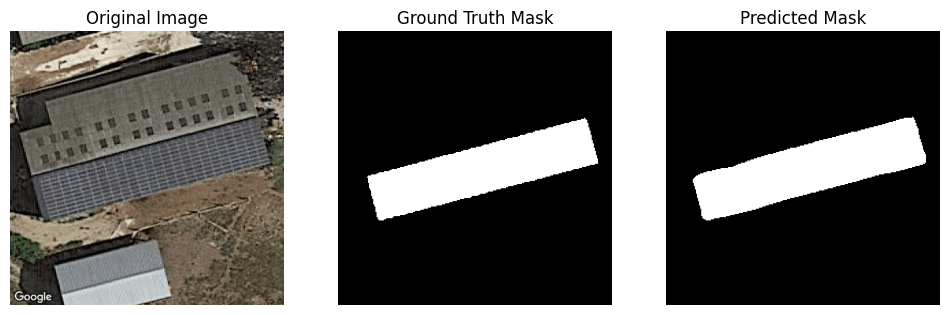

In [ ]:
ROOT = Path('/content/drive/MyDrive/Solor_Panels_Segmentation/model_development_dataset')
img_path = ROOT / 'val/img/IJYJF237BDLZX.png'
mask_path = ROOT / 'val/mask/IJYJF237BDLZX.png'

img = Image.open(img_path).convert('RGB')
mask = Image.open(mask_path).convert('L')

img_t = img_tf(img).unsqueeze(0).to(device)
mask_t = mask_tf(mask).to(device)

with torch.no_grad():
    pred = model(img_t)
    pred_bin = (pred > 0.5).float()
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask_t.squeeze().cpu(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_bin.squeeze().cpu(), cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [ ]:
if device.type == 'cuda':
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    for _ in range(3):
        _ = model(img_t)

    torch.cuda.synchronize()
    starter.record()
    with torch.no_grad():
        pred = model(img_t)
    ender.record()
    torch.cuda.synchronize()

    inference_time = starter.elapsed_time(ender)
    print(f"⚡ GPU inference time: {inference_time:.2f} ms")
else:
    import time
    start = time.time()
    with torch.no_grad():
        pred = model(img_t)
    end = time.time()
    print(f"🕒 CPU inference time: {(end - start)*1000:.2f} ms")

⚡ GPU inference time: 19.47 ms
